# Fast Ellipsoid Intersection Test

Here we explain a fast method for determining whether two $d$-dimensional ellipsoids intersect with each other.

## Method

### Ellipsoid data format

We assume that the $d$-dimensional ellipsoids of interest, $E_A$ and $E_B$, are given as follows:

\begin{align*}
    E_A :=& \{x : (x - \mu_A)^T \Sigma_A^{-1} (x - \mu_A) \le \tau^2\} \\
    E_B :=& \{x : (x - \mu_B)^T \Sigma_B^{-1} (x - \mu_B) \le \tau^2\}
\end{align*}

where
 - $\mu_A \in \mathbb{R}^{d}$ and $\mu_B \in \mathbb{R}^{d}$ are the centerpoints of $E_A$ and $E_B$, respectively,
 - $\Sigma_A \in \mathbb{R}^{d \times d}$ and $\Sigma_B \in \mathbb{R}^{d \times d}$ are symmetric positive definite matrices which define the shape of the ellipsoids.*
 - $\tau\in \mathbb{R}$ is a scalar parameter that determines how big the ellipsoids are.

*The primary axes of $E_A$ are the eigenvectors of $\Sigma_A$, and the lengths of the primary axes are the corresponding eigenvalues multiplied by $\tau$. The shape of $E_B$ is determined by $\Sigma_B$ in the same way.

### Ellipsoid intersection test

Define the scalar function $K:(0,1)\rightarrow \mathbb{R}$,

$$K(s) := 1 - (\mu_b-\mu_a)^T\left(\frac{1}{1-s}\Sigma_A^{-1} + \frac{1}{s}\Sigma_B^{-1}\right)^{-1}(\mu_b-\mu_a).$$

Then $E_A$ intersects $E_B$ if and only if $K(s) \ge 0$ for all $s \in (0,1)$.

This is proven in Proposition 2 in the following paper:
>Gilitschenski, Igor, and Uwe D. Hanebeck. "A robust computational test for overlap of two arbitrary-dimensional ellipsoids in fault-detection of kalman filters." 2012 15th International Conference on Information Fusion. IEEE, 2012.

Therefore, we can quickly determine whether two ellipsoids intersect via the following procedure:
 1. Minimize $K(s)$ on the $(0,1)$ using a fast one-dimensional optimization method.
 2. Check the sign of $K$ at the minimizing point, which we denote by $s^*$.
  - If $K(s^*) > 0$, then the ellipsoids intersect.
  - If $K(s^*) < 0$, then the ellipsoids do not intersect.
  - If $K(s^*)=0$, then the ellipsoids barely touch on their boundaries.

### Speedup using generalized eigenvalue problem

We can avoid perfming matrix computations during the minimization procedure by precomputing the generalized eigenvalues, $\lambda_i$, and generalized eigenvectors, $\phi_i$, of the following generalized eigenvalue problem:

$$\Sigma_A \phi_i = \lambda_i \Sigma_B \phi_i$$

The scaling of the eigenvectors, $\phi_i$, is arbitrary. It is conventional to scale the $\phi_i$ such that $\phi_i^T \Sigma_B \phi_i = 1$. With this scaling, it is well-established that

\begin{align*}
\Phi^T \Sigma_A \Phi =& \Lambda, \\
\Phi^T \Sigma_B \Phi =& I,
\end{align*}
where
 - $\Phi$ is the $d \times d$ matrix whose $i^\text{th}$ column is the vector $\phi_i$.
 - $\Lambda$ is the $d \times d$ diagonal matrix whose $i^\text{th}$ diagonal entry is $\lambda_i$.
 - $I$ is the $d \times d$ identity matrix.

More details on the genearlized eigenvalue problem can be found here:
http://fourier.eng.hmc.edu/e161/lectures/algebra/node7.html

Since $\Sigma_A$ and $\Sigma_B$ are diagonal in the basis of generalized eigenvectors, straightforward algebraic manipulations show that we may write $K(s)$ as follows:

$$K(s) = 1 - \frac{1}{\tau^2}\sum_{i=1}^d v_i^2 \frac{s(1-s)}{1+s(\lambda_i-1)},$$

where $$v := \Phi^T (\mu_A - \mu_B)$$.

## Code

In [1]:
import numpy as np
from scipy.linalg import eigh
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


def ellipsoid_intersection_test(Sigma_A, Sigma_B, mu_A, mu_B, tau):
    lambdas, Phi, v_squared = ellipsoid_intersection_test_helper(Sigma_A, Sigma_B, mu_A, mu_B)
    res = minimize_scalar(ellipsoid_K_function,
                          bracket=[0.0, 0.5, 1.0],
                          args=(lambdas, v_squared, tau))
    return (res.fun[0] >= 0)


def ellipsoid_intersection_test_helper(Sigma_A, Sigma_B, mu_A, mu_B):
    lambdas, Phi = eigh(Sigma_A, b=Sigma_B)
    v_squared = np.dot(Phi.T, mu_A - mu_B) ** 2
    return lambdas, Phi, v_squared


def ellipsoid_K_function(ss, lambdas, v_squared, tau):
    ss = np.array(ss).reshape((-1,1))
    lambdas = np.array(lambdas).reshape((1,-1))
    v_squared = np.array(v_squared).reshape((1,-1))
    return 1.-(1./tau**2)*np.sum(v_squared*((ss*(1.-ss))/(1.+ss*(lambdas-1.))), axis=1)

## Example

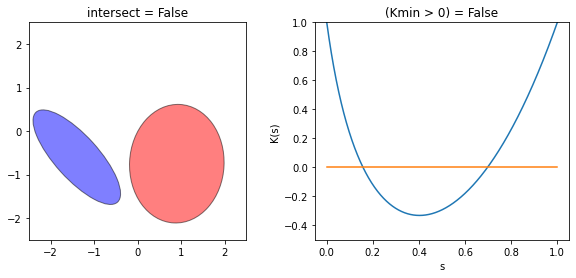

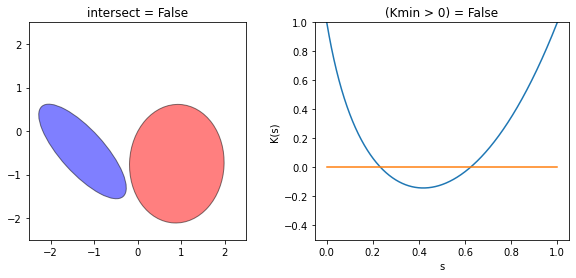

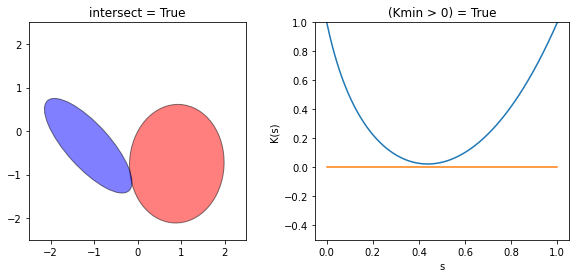

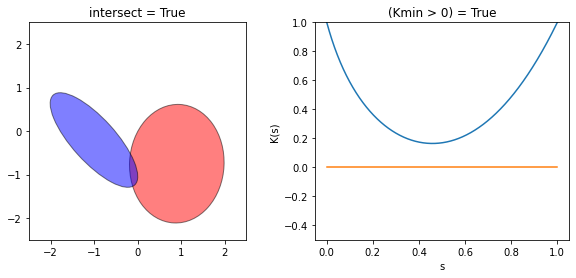

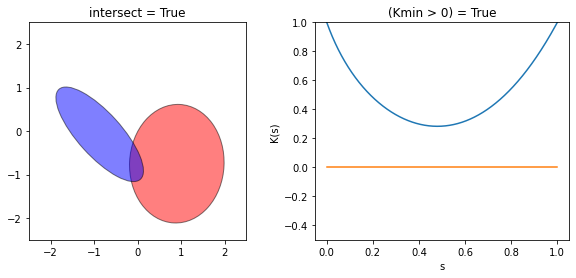

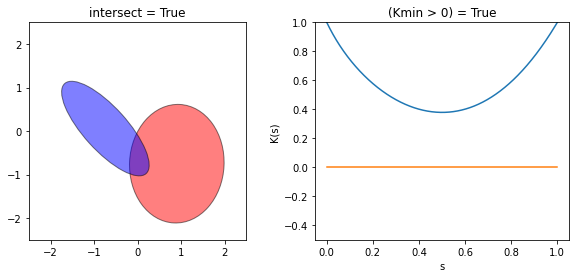

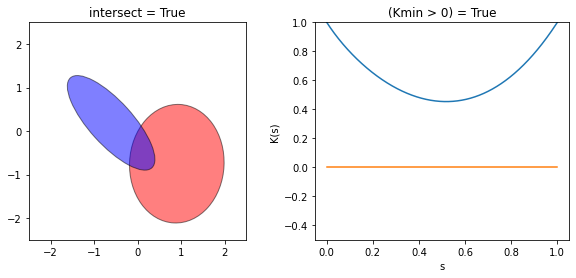

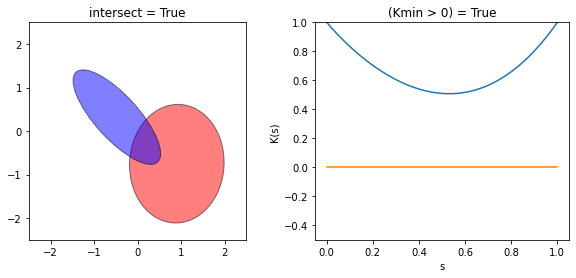

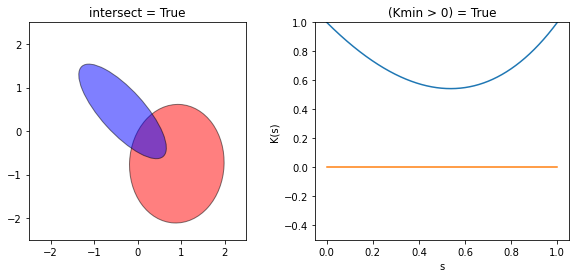

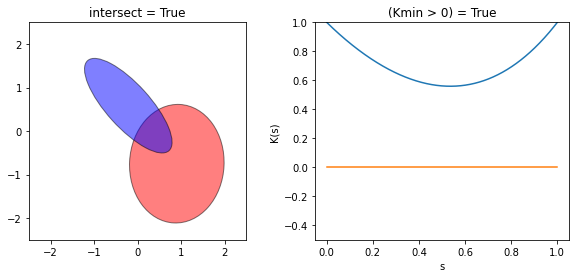

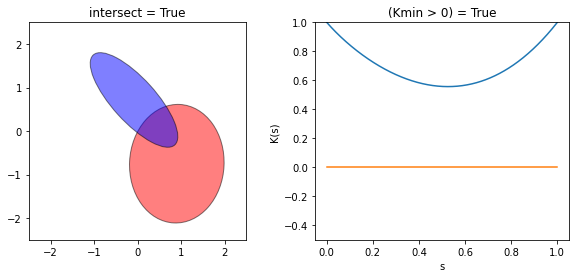

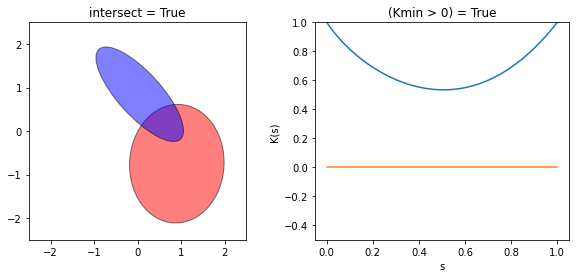

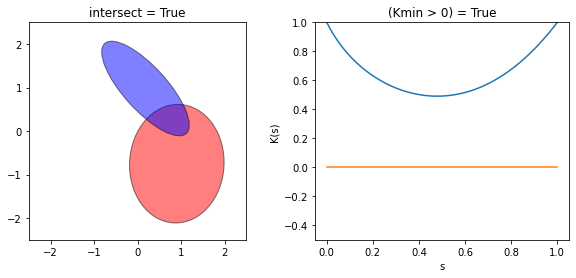

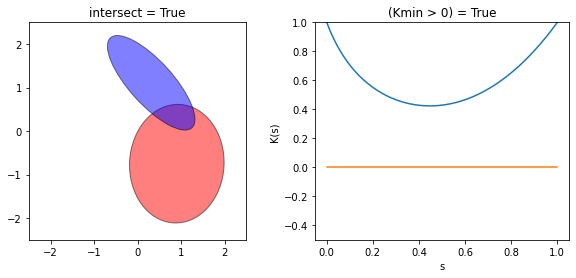

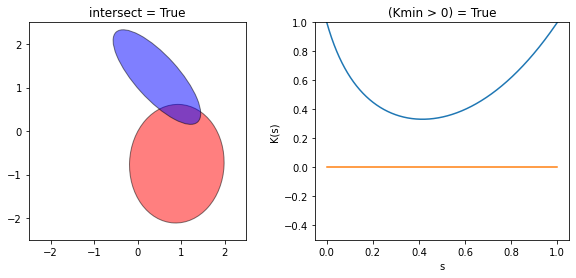

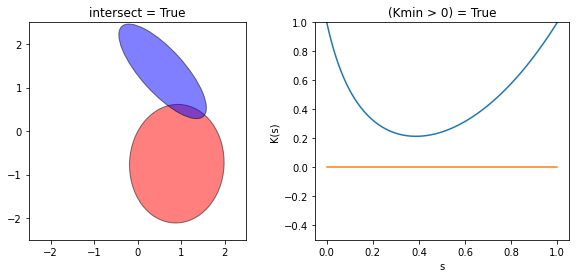

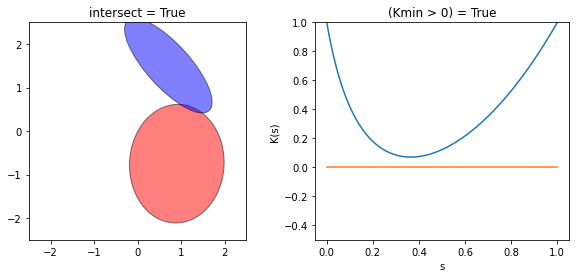

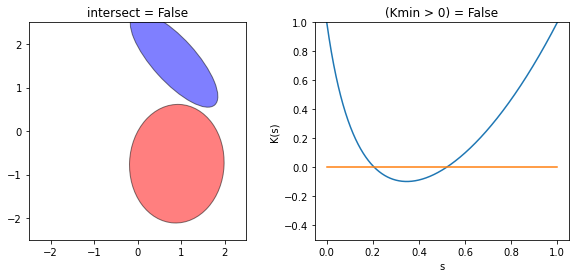

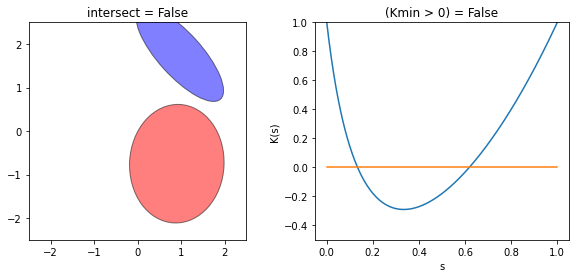

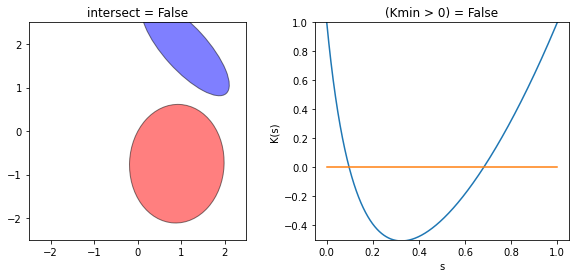

In [2]:
tau=1.3

Sigma_A = np.array([[0.7, 0.02 ], [0.02, 1.1]])
Sigma_B = np.array([[ 0.6, -0.5], [-0.5, 0.7]])

mu_A = np.array([ 0.9, -0.75])
mu_B0 = np.array([-1.4, -0.6])


def plot_ellipse(mu, Sigma, n_std_tau, ax=None, **kwargs):
    # Usage:
    #   https://github.com/NickAlger/nalger_helper_functions/tree/master/jupyter_notebooks/plot_ellipse.ipynb
    if ax is None:
        ax = plt.gca()

    ee, V = np.linalg.eigh(Sigma)
    e_big = ee[1]
    e_small = ee[0]
    v_big = V[:, 1]
    theta = np.arctan(v_big[1] / v_big[0]) * 180. / np.pi

    long_length = n_std_tau * 2. * np.sqrt(e_big)
    short_length = n_std_tau * 2. * np.sqrt(e_small)

    if not ('facecolor' in kwargs):
        kwargs['facecolor'] = 'none'

    ellipse = Ellipse(mu, width=long_length, height=short_length, angle=theta, **kwargs)
    ax.add_artist(ellipse)


dmu = np.array([1.0, 1.0])
tt = np.linspace(0, 2.5, 20)
for ii  in range(len(tt)):
    mu_B = mu_B0 + tt[ii] * dmu

    # min_A, max_A = ellipsoid_bounding_box(mu_A, Sigma_A, tau)
    # min_B, max_B = ellipsoid_bounding_box(mu_B, Sigma_B, tau)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plot_ellipse(mu_A, Sigma_A, n_std_tau=tau, facecolor='r', edgecolor='k', alpha=0.5, linewidth=1)
    plot_ellipse(mu_B, Sigma_B, n_std_tau=tau, facecolor='b', edgecolor='k', alpha=0.5, linewidth=1)
    plt.xlim([-2.5, 2.5])
    plt.ylim([-2.5, 2.5])
    plt.gca().set_aspect(1.0)

    intersect = ellipsoid_intersection_test(Sigma_A, Sigma_B, mu_A, mu_B, tau)
    plt.title('intersect = ' + str(intersect))

    lambdas, Phi, v_squared = ellipsoid_intersection_test_helper(Sigma_A, Sigma_B, mu_A, mu_B)

    ss = np.linspace(0., 1., 1000)
    KK = ellipsoid_K_function(ss, lambdas, v_squared, tau)

    Kmin = np.min(KK)

    plt.subplot(1,2,2)
    plt.plot(ss, KK)
    plt.plot(ss, ss * 0.0)
    plt.title('(Kmin > 0) = ' + str(Kmin > 0))
    plt.ylabel('K(s)')
    plt.xlabel('s')
    plt.ylim([-0.5, 1.0])

